# Deep learning project: Colorizing black and white images

## 0. Introduction
This notebook contains the code and results for the project done by Eric Johansson and Per Ljung in the course Deep machine learning (SSY340/DAT968). The main objective is to take black and white images as input and colorize them using a convolutional neural network, based on the ResNet-18 architecture, in combination with an upsampling scheme. This is further explored by taking sequences of images from classic black and white movies, and see how the network manages to bring these movies to colorful life.

## 1. Collecting and pre-processing of data
As dataset we use the images taken from the <a href="https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/">IMDB-WIKI</a> image dataset. The goal of this section is to
<ol>
  <li>Download the data from IMDB-WIKI.</li>
  <li>Process the data. This includes collecting data from different parts of IMDB-WIkI, and further remove irrelevant data, such as black and white images, etc., since these would affect the training in a negative way.
  <li>Split the data into training, validation and testing datasets.</li>
  <li>Provide a function that can turn a colorful image into black and white format.</li>
  <li>Create dataloaders with built-in color to black and white conversion.</li>
</ol>
We begin by importing necessary modules for the project.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
%pylab inline

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as T
from torchvision import datasets

from skimage import io, color
from skimage.color import lab2rgb, rgb2lab, rgb2gray
import seaborn as sns

import sys, os, time, shutil, re, pickle, cv2
from pathlib import Path
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

Set device to GPU if available.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 1.1 Download data from IMDB-WIKI
To begin with, we will use a subset of the dataset <a href="https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/">IMDB-WIKI</a>, which is an image dataset containing over 500 000 images of celebrities and movie stills. Our subset contains 189,426 images. In ubuntu, this can be done downloaded immediately in the terminal by the command
```
wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_0.tar -P path/to/project
wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_1.tar -P path/to/project
wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar -P path/to/project
```
and then extract each folder into the project directory. Here, the first two consist of random images from IMDb, such as stills from films and gala premieres, while the latter tar-file, `imbd_crop`, contains cropped faces from images. Due to the large occupation of memory (27GB + 26GB + 7GB if using above zip-files), we are satisfied with these. However, if more occupied memory is allowed, one can download even more data using 
```
wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_NUMBER.tar -P path/to/project
```
where `NUMBER` is replaced by any number `2,...,9`. The code below takes the images and divides them into training and validation data.

### 1.2 Process the data
The data we collected in **1.1** have to be gathered into one directory of all images before splitting it. For this process we have written bash scripts that transfers the images to correct folder. Moreover, in the dataset there are numerous black and white images (approximately 5-10%) that will affect the training negatively. Hence, the script checks each image whether it is black and white or colorful, and only includes the colored images. 

To include the cropped images of faces, we shuffle 10,000 images from this directory and remove the ones that are black and white using the script `move_bw.sh`. To include all colored images in the remaining directories, one can use the script `move_imdb_data.sh imdb_NUMBER`, where `NUMBER` is replaced by the directory in question, i.e., `NUMBER=0,1` in our case. Note that running these bash scripts might take a while, since it checks each image wether it is black or white or colored before deciding on wether to accept it or not.

### 1.3 Split data into training and validation
The subset contains 189,426 images. We split it into a training set containing 188,000 images and a validation set with 1,000 images. Remaining images are stored in a sub training set and a sub validation set, used for testing and debugging of code. 

In [ ]:
# Create directories for train and validation
os.makedirs('imdb_images/train/train_subfolder/', exist_ok=True)
os.makedirs('imdb_images/val/val_subfolder/', exist_ok=True)
os.makedirs('imdb_images/subtrain/subtrain_subfolder/', exist_ok=True)
os.makedirs('imdb_images/subval/subval_subfolder/', exist_ok=True)

# Transfer images from downloaded data into directories
data_path = 'imdb_data/'
for i, file in enumerate(os.listdir(data_path)):
    if i < 100:
        os.rename(data_path + file, 'imdb_images/subval/subval_subfolder/' + file)
    elif i < 426:
        os.rename(data_path + file, 'imdb_images/subtrain/subtrain_subfolder/' + file)
    elif i < 1426:
        os.rename(data_path + file, 'imdb_images/val/val_subfolder/' + file)
    else:
        os.rename(data_path + file, 'imdb_images/train/train_subfolder/' + file)

We display some example images below.

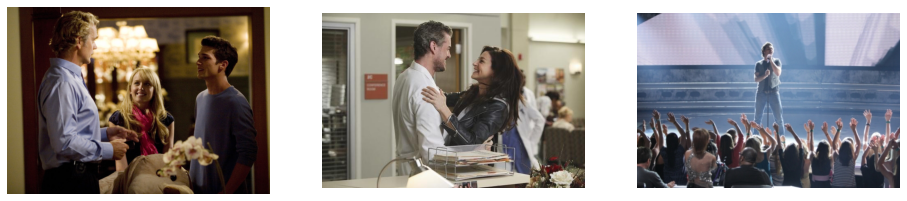

In [4]:
# Plot example images from the training data
n_examples = 3
data_path = 'imdb_images/train/train_subfolder/'
fig, ax = plt.subplots(1, n_examples, figsize=(16, 9))
for i, file in enumerate(os.listdir(data_path)):
    img = mpimg.imread(data_path + file)
    ax[i].imshow(img)
    ax[i].axis('off')
    if i == n_examples - 1:
        break
plt.show()

### 1.4 Visualization of $L^*a^*b^*$ vs RGB images
To get a feel for $L^*a^*b^*$-images the cell below is dedicated for visualization of RGB and $L^*a^*b^*$ images with their different channels. We provide some functions for conversion between the different color spaces. The $a^*$- and $b^*$-channel have additional light added to them for visualization purposes.

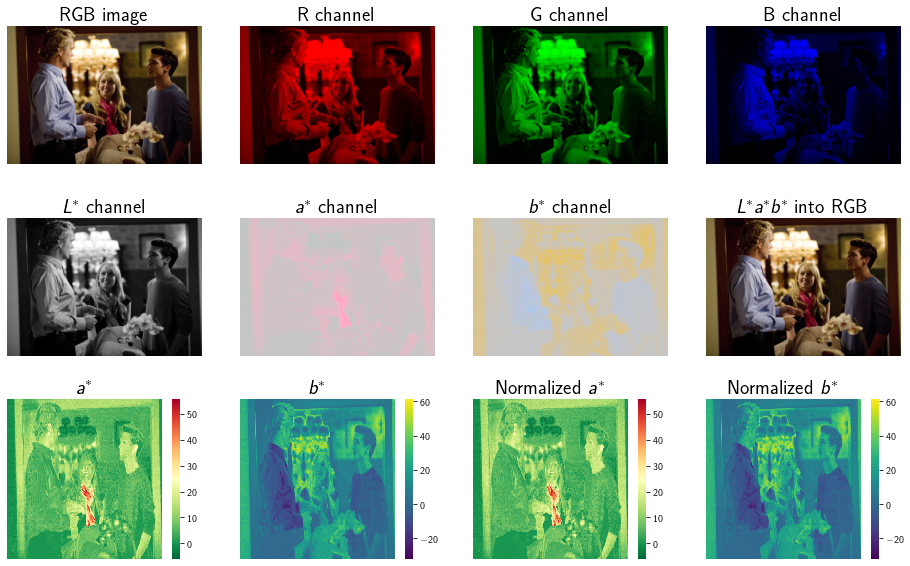

In [4]:
def get_rgb_and_lab_image(filename):
    """Returns (scaled) RGB and L*a*b* images from filename string.

    Parameters
    ----------
    filename : str 
        Path string to file

    Returns
    -------
    rgb_scaled : ndarray
        3D array of size (width, height, 3)
    lab_scaled : ndarray
        3D array of size (width, height, 3)
    """
    rgb = io.imread(filename)
    rgb_scaled = rgb / 255    
    lab = color.rgb2lab(rgb)
    lab_scaled = (lab + [0, 128, 128]) / [100, 255, 255]
    return rgb_scaled, lab_scaled

def get_rgb_channel(image, channel):
    """Returns a specific channel of an RGB image.

    Parameters
    ----------
    image : ndarray 
        3D array of size (width, height, 3)
    channel : int
        What channel to extract: [0, 1, 2] = [red, green, blue]

    Returns
    -------
    rgb_channel : ndarray
        3D array of size (width, height, 3)
    """
    rgb_channel = np.zeros(image.shape)
    rgb_channel[:, :, channel] += image[: ,:, channel]
    return rgb_channel

def get_lab_channel(image, channel):
    """Returns a specific channel of a L*a*b* image.

    Parameters
    ----------
    image : ndarray 
        3D array of size (width, height, 3)
    channel : int
        What channel to extract: [0, 1, 2] = [L*, a*, b*]

    Returns
    -------
    lab_channel : ndarray
        3D array of size (width, height, 3)
    """
    lab_channel = np.zeros(image.shape)
    image = image * [100, 255, 255] - [0, 128, 128] # rescale
    lab_channel[:, :, channel] += image[:, :, channel]
    if channel != 0:
        lab_channel[:, :, 0] += 80 # we need some light for the a and b channels to be visible
    lab_channel = color.lab2rgb(lab_channel)
    return lab_channel

def convert_lab_to_rgb(image):
    """Conversion of L*a*b* image to RGB format.

    Parameters
    ----------
    image : ndarray 
        3D array of size (width, height, 3)

    Returns
    -------
    rgb : ndarray
        3D array of size (width, height, 3)
    """
    rescaled_lab = image * [100, 255, 255] - [0, 128, 128]
    rgb = color.lab2rgb(rescaled_lab)
    return rgb
    
# Pick a file from the training data
data_path = 'imdb_images/train/train_subfolder/'
filename = data_path + next(iter(os.listdir(data_path)))   
    
# Define figure
fig, ax = plt.subplots(3, 4, figsize=(16, 10))
rc('text', usetex=True)
rcParams['text.latex.preamble'] = r'\usepackage[cm]{sfmath}'

# Get RGB and L*a*b* from filename
rgb, lab = get_rgb_and_lab_image(filename)

# Plot full RGB image
ax[0][0].imshow(rgb)
ax[0][0].set_title('RGB image', fontsize=20)
ax[0][0].axis('off')

# Plot each channel of RGB image
for i, title in enumerate(['R channel', 'G channel', 'B channel']):
    ax[0][i + 1].imshow(get_rgb_channel(rgb, i))
    ax[0][i + 1].set_title(title, fontsize=20)
    ax[0][i + 1].axis('off')
    
# Plot each channel of L*a*b* image
for i, title in enumerate(['$L^*$ channel', '$a^*$ channel', '$b^*$ channel']):
    ax[1][i].imshow(get_lab_channel(lab, i))
    ax[1][i].set_title(title, fontsize=20)
    ax[1][i].axis('off')
    
# Plot L*a*b* image converted back to RGB
ax[1][3].imshow(convert_lab_to_rgb(lab))
ax[1][3].set_title('$L^*a^*b^*$ into RGB', fontsize=20)
ax[1][3].axis('off')

# Plot lab ab channels values
titles = ['$a^*$', '$b^*$', 'Normalized $a^*$', 'Normalized $b^*$']
cmaps = ['RdYlGn_r', 'viridis', 'RdYlGn_r', 'viridis']
for i, (title, cm) in enumerate(zip(titles, cmaps)):
    sns.heatmap(lab[:, :, i % 2 + 1] * 255 - 128, ax=ax[2][i], cmap=cm)
    ax[2][i].set(xticks=[])
    ax[2][i].set(yticks=[])
    ax[2][i].set_title(title, fontsize=20)


### 1.5 Create dataset  
It is convinient for us to create a custom dataset and use this to convert images to $L^*a^*b^*$ format. We let our dataset inherit `datasets.ImageFolder` and override the `__getitem__` method from <a href="https://github.com/pytorch/vision/blob/3e60fb29986ad74d9e4dc5715479d7bd3d8b59ba/torchvision/datasets/folder.py#L108-L144">this function</a>, such that we can use a dataloader to directly sample grayscale images (the lightness channel from LAB-images) used as input to our network and images containing only the $a^*$- and $b^*$-channels from $L^*a^*b^*$-images later used as targets to our network.  

We construct dataloaders for each different training and validation set. For all sets, transformations are used to resize all images to size `256 x 256`. For the main training dataloader, we furthermore apply some data augmentation in the sense of random cropping and random horizontal flips.

In [5]:
class LABImageFolder(datasets.ImageFolder):

    # Override __getitem__ method from datasets.ImageFolder so it converts to L*a*b* format
    def __getitem__(self, index):
        path, target = self.imgs[index]
        sample = self.loader(path)
    
        if self.transform is not None:
            rgb_image = self.transform(sample)
            lab = color.rgb2lab(rgb_image)
            lab_scaled = (lab + [0, 128, 128]) / [100, 255, 255]
            L_channel = np.zeros(lab_scaled.shape[0:2])
            L_channel += lab_scaled[:, :, 0]
            ab_channels = np.zeros(lab_scaled.shape[0:2] + (2,))
            ab_channels += lab_scaled[:, :, 1:3]
            sample_grayscale = torch.from_numpy(L_channel)
            sample_ab = torch.from_numpy(ab_channels).permute(2, 0, 1).float()
            sample_grayscale = torch.unsqueeze(sample_grayscale, 0).float()

        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample_grayscale, sample_ab, target

# Parameters for dataloaders
img_size = 256
train_batch_size = 64
val_batch_size = 64

# Transform with data augmentation
train_transforms = T.Compose([T.RandomHorizontalFlip(), 
                             T.RandomResizedCrop((img_size, img_size), scale=(0.7,1))])
# Train loader
train_imagefolder = LABImageFolder('imdb_images/train/', train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=train_batch_size, shuffle=True)

# Validation loader
val_transforms = T.Compose([T.Resize((img_size, img_size))])
val_imagefolder = LABImageFolder('imdb_images/val/' , val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=val_batch_size, shuffle=False)

# Subtrain loader
subtrain_transforms = T.Compose([T.Resize((img_size, img_size))])
subtrain_imagefolder = LABImageFolder('imdb_images/subtrain/', subtrain_transforms)
subtrain_loader = torch.utils.data.DataLoader(subtrain_imagefolder, batch_size=train_batch_size, shuffle=True)

# Subvalidation loader 
subval_transforms = T.Compose([T.Resize((img_size, img_size))])
subval_imagefolder = LABImageFolder('imdb_images/subval/' , subval_transforms)
subval_loader = torch.utils.data.DataLoader(subval_imagefolder, batch_size=val_batch_size, shuffle=False)

Test dataloader by plotting lightness and $a^*b^*$-channels from an image of `train_loader`.

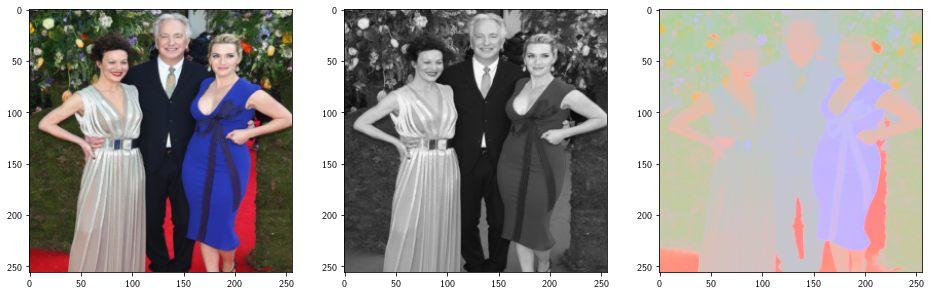

In [6]:
def plot_lab(sample_lightness, sample_ab):
    """Plots full image, lightness, and a*b*-channels.

    Parameters
    ----------
    sample_lightness : Tensor 
        3D Tensor of shape (1, width, height)
    sample_ab : Tensor 
        3D Tensor of shape (2, width, height)
    """
    
    # Convert to suitable dimensions
    sample_lightness = sample_lightness.squeeze(0); sample_ab = sample_ab.permute(1, 2, 0)
    
    # Initialize zero tensors
    lab = torch.zeros(sample_lightness.shape + (3,))
    l = torch.zeros(sample_lightness.shape + (3,))
    ab = torch.zeros(sample_lightness.shape + (3,))
    
    # Convert lightness channel
    l[:, :, 0] += sample_lightness * 100
    l = color.lab2rgb(l)
    
    # Convert ab channel
    ab[:, :, 0] += 80
    ab[:, :, 1:3] += sample_ab * 255 - 128
    ab = color.lab2rgb(ab)
    
    # Put together full image
    lab[:, :, 0] = sample_lightness * 100
    lab[:, :, 1:3] = sample_ab * 255 - 128
    lab = color.lab2rgb(lab)
    
    # Plot full image together with lightness and ab channels
    fig, ax = plt.subplots(1, 3, figsize=(16, 10))
    ax[0].imshow(lab)
    ax[1].imshow(l)
    ax[2].imshow(ab)
    
samples_grayscale, samples_ab, _ = next(iter(train_loader))
plot_lab(samples_grayscale[0], samples_ab[0])

## 2. Network architecture and training

It is time to define the network and start training. The work is separated into following parts.
<ol>
    <li>Define network.</li>
    <li>Create network, or load it from previous runs.</li>
    <li>Construct handy methods for training and validation.</li>
    <li>Train network!</li>
    <li>Visualize results validated by trained network.</li>
    <li>Construct a film that plays the black and white vs the colorized version.</li>
</ol>

### 2.1 Define network
The network is constructed by a first half that downsamples the image and look for features within it. This is based on the ResNet-18 module. One can either use the version pretrained on ImageNet, or train one from scratch. Throughout our experiments, we have not noticed much particular differences between both cases, and therefore have gone for the non-pretrained, and left the pretrained part as an option in the code. Note that ResNet-18 is designed to take RGB images as input, and therefore the first layer must be altered since we will now pass a single chanel as input. The second part consists of an upsampling scheme, in combination with batch normalization and ReLU activation functions between all upsampling layers. 

In [7]:
class ColorizationNet(nn.Module):
    def __init__(self, input_size=128):
        super(ColorizationNet, self).__init__()
        MIDLEVEL_FEATURE_SIZE = 128

        # Use ResNet-18 as first half
        # No particular difference noticed between pretrained or not
        pretrained = False
        if pretrained:
            resnet = models.resnet18(pretrained=True) 
        else:
            resnet = models.resnet18(num_classes = 300) 
        
        # hange first convolutional layer to accept a single channel as input
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
        
        # Extract midlevel features
        self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

        # Second half: Upsampling
        self.upsample = nn.Sequential(     
          nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Upsample(scale_factor=2),
          nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Upsample(scale_factor=2),
          nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
          nn.Upsample(scale_factor=2)
        )

    def forward(self, input):

        # Construct midlevel features for upsampling
        midlevel_features = self.midlevel_resnet(input)

        # Upsample midlevel features to retrieve colors
        output = self.upsample(midlevel_features)
        return output

### 2.2 Create (or load) network
Construct network, including optimizer (ADAM) and loss (MSE). Moreover, there is the choice of loading an earlier trained version.

In [8]:
model = ColorizationNet()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0)
load_model = True
load_path = 'checkpoints/current_model_0.00219.pth'
if os.path.isfile(load_path) and load_model:
    model.load_state_dict(torch.load(load_path))
    print('Model loaded')

Model loaded


### 2.3 Create handy functions for training and validation
These functions defined below, used for training and validation of the network, are highly inspired by the code written in  <a href="https://lukemelas.github.io/image-colorization.html">this post</a>.

In [9]:
class AverageMeter(object):
    '''A handy class from the PyTorch ImageNet tutorial''' 
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
    '''Show/save rgb image from grayscale and ab channels
    Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
    plt.clf()
    color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
    color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
    color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
    color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
    color_image = lab2rgb(color_image.astype(np.float64))
    grayscale_input = grayscale_input.squeeze().numpy()
    if save_path is not None and save_name is not None: 
        plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
        plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))


In [10]:
def validate(val_loader, model, criterion, save_images, epoch):
    model.eval()

    # Prepare value counters and timers
    batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

    end = time.time()
    already_saved_images = False
    for i, (input_gray, input_ab, target) in enumerate(val_loader):
        data_time.update(time.time() - end)

        # Use GPU if available
        input_gray, input_ab, target = input_gray.to(device),  input_ab.to(device), target.to(device)

        # Run model and record loss
        output_ab = model(input_gray)
        loss = criterion(output_ab, input_ab)
        losses.update(loss.item(), input_gray.size(0))

        # Save images to file
        if save_images and not already_saved_images:
            already_saved_images = True
            for j in range(len(output_ab)):
                save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
                save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
                to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

        # Record time to do forward passes and save images
        batch_time.update(time.time() - end)
        end = time.time()

        # Print model accuracy
        if i % 10 == 0:
            print('Validate: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                      i, len(val_loader), batch_time=batch_time, loss=losses))

    print('Finished validation.')
    return losses.avg

def train(train_loader, model, criterion, optimizer, epoch):
    print('Starting training epoch {}'.format(epoch))
    model.train()

    # Prepare value counters and timers
    batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()
    
    train_loss_batches = []
    train_loss_avg = 0
    num_batches = len(train_loader)

    end = time.time()
    for batch_index, (input_gray, input_ab, target) in enumerate(train_loader):

        # Use GPU if available
        input_gray, input_ab, target = input_gray.to(device),  input_ab.to(device), target.to(device)

        # Record time to load data (above)
        data_time.update(time.time() - end)

        # Run forward pass
        output_ab = model(input_gray) 
        loss = criterion(output_ab, input_ab) 
        losses.update(loss.item(), input_gray.size(0))
        train_loss_batches.append(loss.item())
        train_loss_avg += loss.item()

        # Compute gradient and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record time to do forward and backward passes
        batch_time.update(time.time() - end)
        end = time.time()

        # Print model accuracy
        if batch_index % 10 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                      epoch, batch_index, num_batches, batch_time=batch_time,
                      data_time=data_time, loss=losses)) 

    print('Finished training epoch {}'.format(epoch))
    return train_loss_batches, train_loss_avg / num_batches

In [11]:
# Pass model to GPU if available
criterion = criterion.to(device)
model = model.to(device)

In [12]:
# Construct output folders
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
save_images = True

# Load losses if model has been loaded
if load_model:
    best_losses  = float(re.search('current_model_(.+?).pth', load_path).group(1))
else:
    best_losses = 1e10

# Load losses
load_losses = True
if load_losses:
    with open("losses/train_losses.txt", "rb") as fp:
        train_losses_list = pickle.load(fp)
    with open("losses/val_losses.txt", "rb") as fp:
        val_losses_list = pickle.load(fp)
else:
    full_train_avg_losses, full_val_avg_losses = [], []
    
epochs = 10

### 2.4 Time to train network!
Time to train the network. After each epoch, we check wether the losses are better than the previous `best_losses`, and in that case, we save the model into our `checkpoints/` directory. We furthermore store the loss function values in lists that are later to be stored in a separate folder.

In [ ]:
# Train model
for epoch in range(epochs):
    # Train for one epoch, then validate
    _, train_avg_losses = train(train_loader, model, criterion, optimizer, epoch)
    with torch.no_grad():
        val_avg_losses = validate(val_loader, model, criterion, save_images, epoch)
    # Save checkpoint and replace old best model if current model is better
    if val_avg_losses < best_losses:
        best_losses = val_avg_losses
        torch.save(model.state_dict(), 'checkpoints/model-epoch-{}-losses-{:.6f}.pth'.format(epoch + 1, losses))
    train_losses_list.append(train_avg_losses)
    val_losses_list.append(val_avg_losses)


In [ ]:
# Store loss function data for training and validation
with open("losses/train_losses.txt", "wb") as fp:
    pickle.dump(train_losses_list, fp)
with open("losses/val_losses.txt", "wb") as fp:
    pickle.dump(val_losses_list, fp)

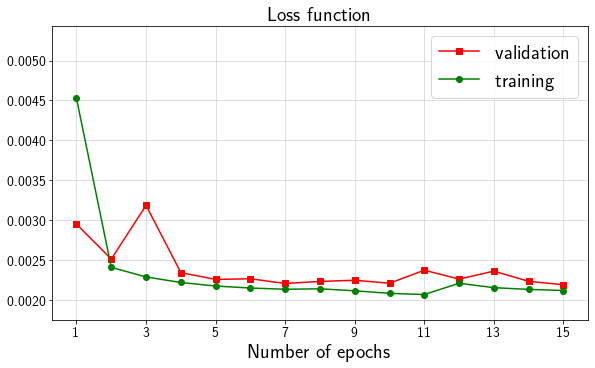

In [18]:
def plot_loss(train_losses, val_losses, save_fig):
    """Plots the loss as function of number of epochs.

    Parameters
    ----------
    train_losses : list 
        List containing train loss for each epoch
    val_losses : list 
        List containing validation loss for each epoch
    save_fig : bool
        True if figure should be saved
    """
    
    # Initialize figure
    ratio = 0.6
    fig, ax = plt.subplots(figsize=(ratio * 16, ratio * 9))

    # Plot loss
    ax.plot(range(1, len(val_losses) + 1), val_losses, '-s', color='r', label='validation')
    ax.plot(range(1, len(train_losses) + 1), train_losses, '-o', color='g', label='training')
    ax.set_title('Loss function', fontsize=20)
    ax.set_xlabel('Number of epochs', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(alpha=0.5)
    ax.set_xticks(range(1, len(val_losses) + 1, 2))
    ax.legend(fontsize=20)
    ax.set_ylim((0.8 * min(min(train_losses, val_losses)), 
                 1.2 * max(max(train_losses, val_losses))))
    
    if save_fig:
        fig.savefig('figures/loss.eps', bbox_inches='tight')

save_fig = False
plot_loss(train_losses_list, val_losses_list, save_fig)

In [15]:
# Save current model
torch.save(model.state_dict(), 'checkpoints/current_model_{:.5f}.pth'.format(losses))

### 2.5 Visualize validation images and compare with input
First of all, we define a function that stores input data into an `inputs/` directory, so we can compare validated data to ground truth.

In [13]:
def save_input_data(sample_lightness, sample_ab, num):
    """Constructs and stores input data into inputs/ directory

    Parameters
    ----------
    sample_lightness : Tensor 
        3D Tensor of shape (1, width, height)
    sample_ab : Tensor 
        3D Tensor of shape (2, width, height)
    num : int
        What number the image should be stored as
    """

    # Check if inputs/ directory exists and otherwise create it
    Path('inputs/').mkdir(parents=True, exist_ok=True)
    
    # Convert to suitable dimensions
    sample_lightness = sample_lightness.squeeze(0); sample_ab = sample_ab.permute(1,2,0)
    
    # Initialize zero tensors
    lab = torch.zeros(sample_lightness.shape + (3,))
    
    # Put together full image
    lab[:, :, 0] = sample_lightness * 100
    lab[:, :, 1:3] = sample_ab * 255 - 128
    lab = color.lab2rgb(lab)
    
    # Store image in inputs/ without plotting it in notebook
    fig = plt.figure()
    plt.imshow(lab)
    plt.axis('off')
    plt.savefig('inputs/{}.jpg'.format(num), bbox_inches='tight')
    plt.close()
    
n_imgs_batch = 0
for i, (samples_grayscale, samples_ab, _) in enumerate(iter(subval_loader)):
    if i == 0:
        n_imgs_batch = samples_grayscale.shape[0]
        
    for j in range(samples_grayscale.shape[0]):
        save_input_data(samples_grayscale[j], samples_ab[j], i * n_imgs_batch + j)


Time to validate sequence of images for different scenes from films. The films we take scenes from are 
- <a href="https://www.imdb.com/title/tt0054215/?ref_=nv_sr_srsg_3">Psycho (1960)</a>
- <a href="https://www.imdb.com/title/tt0034583/?ref_=nv_sr_srsg_0">Casablanca (1942)</a>
- <a href="https://www.imdb.com/title/tt0050083/?ref_=nv_sr_srsg_0">12 Angry Men (1957)</a>
- <a href="https://www.imdb.com/title/tt0033467/?ref_=nv_sr_srsg_0">Citizen Kane (1942)</a>
- <a href="https://www.imdb.com/title/tt0031679/?ref_=nv_sr_srsg_0">Mr Smith Goes to Washington (1939)</a>
- <a href="https://www.imdb.com/title/tt0057565/?ref_=nv_sr_srsg_0">High and Low (1963)</a>

as seen listed below in the directory `films/`.

In [31]:
os.listdir('films/')

['psycho',
 'casablanca',
 '12_angry_men',
 'citizen_kane',
 'mr_smith_goes_to_washington',
 'high_and_low']

In [102]:
def validate_film(film_loader, model, film):
    """Colorizes black and white film stills and store results

    Parameters
    ----------
    film_loader : DataLoader 
        DataLoader of black and white images from a film
    model : ColorizationNet 
        Trained network
    film : str
        String path to film stills directory
    """
    
    model.eval()

    for i, (input_gray, input_ab, target) in enumerate(film_loader):

        # Use GPU
        input_gray, input_ab = input_gray.to(device),  input_ab.to(device)

        # Run model
        output_ab = model(input_gray) 

        # Save images to file
        for j in range(len(output_ab)):
            save_path = {'grayscale': 'film_results/' + film + 'outputs/gray/',
                         'colorized': 'film_results/' + film + 'outputs/color/'}
            save_name = film[6:-1] + '-img-{}.jpg'.format(i * film_loader.batch_size + j)
            to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, 
                   save_name=save_name)

    print('Finished validation of ' + film[6:-1].replace("_", " ").title())

for film in os.listdir('films/'):

    # Check if folder exists and otherwise create it
    film =  'films/' + film + '/'
    Path('film_results/' + film + 'outputs/gray/').mkdir(parents=True, exist_ok=True)
    Path('film_results/' + film + 'outputs/color/').mkdir(parents=True, exist_ok=True)

    # Create its corresponding dataloader
    film_transform = T.Compose([T.Resize((img_size, img_size))])
    film_imagefolder = LABImageFolder(film, film_transform)
    film_loader = torch.utils.data.DataLoader(film_imagefolder, batch_size=10, shuffle=False)

    # Validate and store results
    validate_film(film_loader, model, film)

Finished validation of Psycho
Finished validation of Casablanca
Finished validation of 12 Angry Men
Finished validation of Citizen Kane
Finished validation of Mr Smith Goes To Washington
Finished validation of High And Low


<Figure size 432x288 with 0 Axes>

The code below takes the input black and white images and concatenates it with the colorize to create jpg-files that compare input and output side by side, and stores the results in `outputs/combined/`.

In [103]:
# Combine gray and colorized images
for film in os.listdir('films/'):

    # Make sure folder exists
    Path('film_results/films/' + film + '/outputs/combined/').mkdir(parents=True, exist_ok=True)

    # Path to image folders
    color_path = 'film_results/films/' + film + '/outputs/color/'
    gray_path = 'film_results/films/' + film + '/outputs/gray/'
    
    # List of image files, sorted in correct sequence
    colors = os.listdir(color_path)
    grays = os.listdir(gray_path)
    colors.sort(key=lambda x: int(x.split('.')[0].split('-')[-1]))
    grays.sort(key=lambda x: int(x.split('.')[0].split('-')[-1]))
    
    # Concatenate and save image
    for i, (x, y) in enumerate(zip(colors, grays)):
        c = Image.open(color_path + x)
        g = Image.open(gray_path + x)

        widths, heights = zip(*(i.size for i in [c, g]))
        total_width = sum(widths)
        max_height = max(heights)

        new_im = Image.new('RGB', (total_width, max_height))

        x_offset = 0
        for im in [g, c]:
            new_im.paste(im, (x_offset,0))
            x_offset += im.size[0]

        new_im.save('film_results/films/' + film + '/outputs/combined/' + film[:-1] + '-{}.jpg'.format(i))

In [104]:
# Move results to one combined folder
from shutil import copy

dst = 'film_results/final'
Path(dst).mkdir(parents=True, exist_ok=True)
for film in os.listdir('films/'):
    src = 'film_results/films/' + film + '/outputs/combined/'
    for root, _, files in os.walk(src):
        for file in files:
            copy(os.path.join(root, file), dst)

We now plot examples from the computed stills. This is done below for *Psycho (1960)*, *High and Low (1963)*, and *12 Angry Men (1957)*.

In [33]:
def plot_film(indices, film, save_fig=False):
    """Plots colorized and input stills from film

    Parameters
    ----------
    indices : list 
        List of indices of images to plot
    film : str
        String of the film's directory name
    save_fig : bool
        True if figure is to be saved to figures/film.jpg
    """
    fig, ax = plt.subplots(2, len(indices))
    for i, idx in enumerate(indices):
        in_data = 'film_results/films/' + film + '/outputs/gray/' + film + '-img-{}.jpg'.format(idx)
        out_data = 'film_results/films/' + film + '/outputs/color/' + film + '-img-{}.jpg'.format(idx)

        color = mpimg.imread(out_data)
        gray  = mpimg.imread(in_data)
        ax[1][i].imshow(gray, cmap='gray')
        ax[0][i].imshow(color)
        ax[0][i].axis('off'), ax[1][i].axis('off')

    fig.tight_layout()
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()
    if save_fig:
        Path('figures/').mkdir(parents=True, exist_ok=True)
        fig.savefig('figures/{}.jpg'.format(film), bbox_inches='tight')
        plt.close()
        

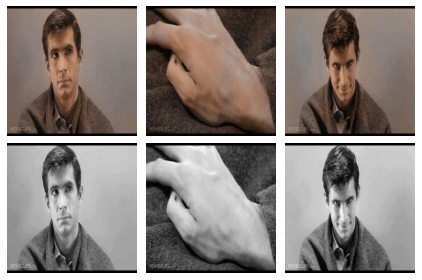

In [34]:
# Plot for Psycho
indices = [250, 300, 400]
film = 'psycho'
plot_film(indices, film, save_fig=True)

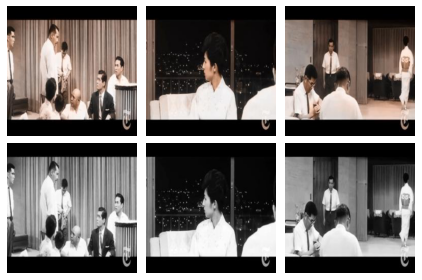

In [35]:
# Plot for High and Low
indices = [54, 135, 197]
film = 'high_and_low'
plot_film(indices, film, save_fig=True)

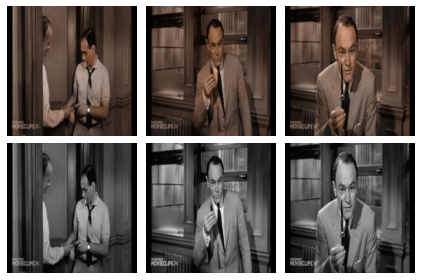

In [36]:
# Plot for 12 Angry Men
indices = [10, 100, 150]
film = '12_angry_men'
plot_film(indices, film, save_fig=True)

### 2.6 Save to film and play
We finish by constructing a film from our resulted jpg-files and show the results given.

In [156]:
# Convert film images into mp4 video
Path('videos/').mkdir(parents=True, exist_ok=True)
for film in os.listdir('films/'):
    image_folder = 'film_results/films/' + film + '/outputs/combined/'
    video_name = 'videos/' + film + '.mp4'

    images = sorted([img for img in os.listdir(image_folder) if img.endswith(".jpg")],
                    key=lambda x: int(x.split('.')[0].split('-')[-1]))
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    fps = 15
    video = cv2.VideoWriter(video_name, fourcc, fps, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()

We can now play the video file created. Note that some web browser have problem playing this type of file, and might result in a "No video with supported format and MIME type found.", in which case, one can check the video from the project directory.

In [1]:
from IPython.display import Video

Video("psycho.mp4", embed=True)